In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
from cartopy.mpl.gridliner import LatitudeFormatter, LongitudeFormatter
from scipy.stats import ttest_ind
from sofia_project.util import cleanocn
from xesmf import Regridder

dask.config.set(scheduler="single-threaded")

mpl.rcParams["figure.figsize"] = 6, 4
mpl.rcParams["font.size"] = 12

In [2]:
croot = Path("../data/processed/HadGEM3-GC31-LL")

expts = ["historical", "ssp585"]

In [5]:
ctrldata = {}

for exp in expts:
    print(exp)

    if exp == "historical":
        histdir = croot.joinpath("historical", "Amon", "pr")
        sspdir = croot.joinpath("ssp245", "Amon", "pr")

        tspan = slice("2015-01", "2020-12")

        nch = list(histdir.glob("*ens_gn*.nc"))[0]
        ncs = list(sspdir.glob("*ens_gn*201501*.nc"))[0]

        dshist = xr.open_dataset(nch)

        dahist = dshist["pr"].sel(time=slice("1992-01", "2014-12"))
    else:
        sspdir = croot.joinpath("ssp585", "Amon", "pr")
        ncs = list(sspdir.glob("*ens_gn*210012.nc"))[0]
        tspan = slice("2071-01", "2100-12")

    dsssp = xr.open_dataset(ncs)

    dassp = dsssp["pr"].sel(time=tspan)

    if exp == "historical":
        dac = xr.concat((dahist, dassp), dim="time")
    else:
        dac = dassp

    ctrldata[exp] = dac * 24 * 3600

historical
ssp585


In [8]:
sofdata = {}
for exp in expts:
    print(exp)

    if exp == "historical":
        sofdir = croot.joinpath("hist-antwater-92-11", "Amon", "pr")
    else:
        sofdir = croot.joinpath("ssp585-ismip6-water", "Amon", "pr")

    ncsof = list(sofdir.glob("*ens_gn*.nc"))[0]

    dssof = cleanocn(xr.open_dataset(ncsof))

    dasof = dssof["pr"] * 24 * 3600

    sofdata[exp] = dasof

historical
ssp585


In [9]:
def stattest2d(ctrl, expt):
    tstat, pval = ttest_ind(ctrl, expt)

    xpval = xr.DataArray(
        pval,
        coords={
            "lat": ("lat", ctrl.lat.data),
            "lon": ("lon", ctrl.lon.data),
        },
        dims=["lat", "lon"],
    )

    tanom = (expt - ctrl).mean("year")

    return xpval, tanom

In [10]:
anomdict = {}
pvaldict = {}

for exp in expts:
    print(exp)
    if exp == "historical":
        tspan = slice("2011-01", "2020-12")
    else:
        tspan = slice("2071-01", "2100-12")

    dac_an = ctrldata[exp].sel(time=tspan).groupby("time.year").mean("time").compute()
    dasof_an = sofdata[exp].sel(time=tspan).groupby("time.year").mean("time").compute()

    pval, anom = stattest2d(dac_an, dasof_an)

    anomdict[exp] = anom
    pvaldict[exp] = pval

historical
ssp585


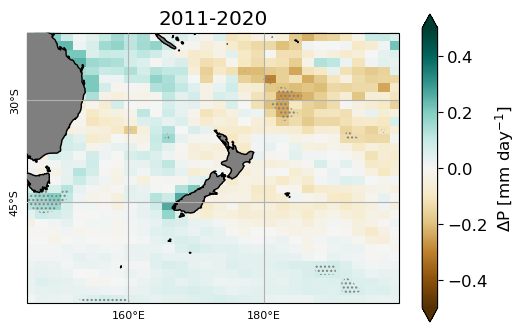

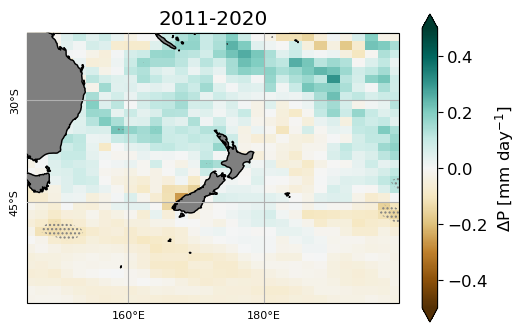

In [11]:
for exp in expts:
    fig = plt.figure()
    axs = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    axs.add_feature(cfeature.LAND, color="tab:gray", zorder=100)
    axs.coastlines(zorder=101)
    axs.set_extent([145, 200, -60, -20], crs=ccrs.PlateCarree())
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, zorder=102)
    gl.xlocator = mticker.FixedLocator([160, 180])
    gl.ylocator = mticker.FixedLocator([-45, -30, -15])
    gl.top_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    gl.xformatter = LongitudeFormatter(dateline_direction_label=True)
    gl.xlabel_style = {'size': 8, 'color': 'k'}
    gl.ylabel_style = {'size': 8, 'color': 'k', 'rotation': 90}
    im = anomdict[exp].plot.pcolormesh(
        "lon",
        "lat",
        ax=axs,
        transform=ccrs.PlateCarree(),
        cmap="BrBG",
        cbar_kwargs={"label": "$\Delta$P [mm day$^{-1}$]", "extend": "both"},
    )
    im.set_clim(-0.5, 0.5)

    levels = [0, 0.05, 0.1, 1]
    cs = pvaldict[exp].plot.contourf(
        "lon",
        "lat",
        ax=axs,
        transform=ccrs.PlateCarree(),
        levels=levels,
        hatches=["....", "", ""],
        colors="none",
        add_colorbar=False,
    )

    cs.set_edgecolor("tab:gray")
    cs.set_linewidth(0.0)

    axs.set_title("2011-2020")

    fig.savefig(
        f"../figures/pr_sofia_tier2_{exp}_nz.png", bbox_inches="tight", dpi=300
    )

In [12]:
def seas_subset(data):
    data_seas = data.resample(time="QE-FEB").mean("time").compute()
    data_seas = data_seas.isel(time=slice(1, -1))
    mam = data_seas.isel(time=slice(0, None, 4)).groupby("time.year").mean("time")
    jja = data_seas.isel(time=slice(1, None, 4)).groupby("time.year").mean("time")
    son = data_seas.isel(time=slice(2, None, 4)).groupby("time.year").mean("time")
    djf = data_seas.isel(time=slice(3, None, 4)).groupby("time.year").mean("time")

    out = xr.concat([djf, mam, jja, son], dim="season")
    out = out.assign_coords({"season": ("season", ["DJF", "MAM", "JJA", "SON"])})

    return out

In [13]:
def stattestseas(ctrl, expt):
    tstat, pval = ttest_ind(ctrl, expt, axis=0)

    coords = {
        "lat": ("lat", ctrl.lat.data),
        "lon": ("lon", ctrl.lon.data),
    }

    xpval = xr.DataArray(pval, dims=("lat", "lon"), coords=coords)

    tanom = (expt - ctrl).mean("year")

    return xpval, tanom

In [14]:
anomdictseas = {}
pvaldictseas = {}

for exp in expts:
    print(exp)
    if exp == "historical":
        tspan = slice("2011-01", "2020-12")
    else:
        tspan = slice("2071-01", "2100-12")

    ctrl = seas_subset(ctrldata[exp].sel(time=tspan))
    expt = seas_subset(sofdata[exp].sel(time=tspan))

    tanom = xr.zeros_like(ctrl.mean("year"))
    pval = xr.zeros_like(ctrl.mean("year"))

    for n, seas in enumerate(ctrl.season.data):
        print(seas)
        tmpc = ctrl.sel(season=seas)
        tmpe = expt.sel(season=seas)

        if seas == "DJF":
            tmpc = tmpc.isel(year=slice(1, None))
            tmpe = tmpe.isel(year=slice(1, None))

        pval[n, ...], tanom[n, ...] = stattestseas(tmpc, tmpe)

    anomdictseas[exp] = tanom
    pvaldictseas[exp] = pval

historical
DJF
MAM
JJA
SON
ssp585
DJF
MAM
JJA
SON


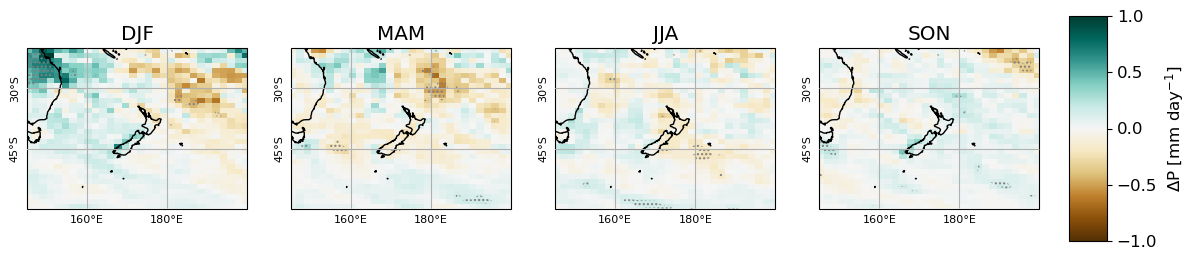

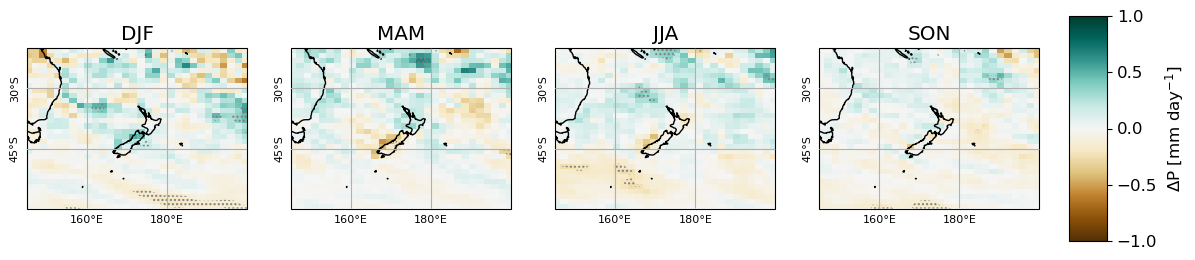

In [15]:
for exp in expts:
    fig, axs = plt.subplots(
        1,
        4,
        figsize=(15, 3),
        subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)},
    )

    for s, seas in enumerate(tanom.season.data):
        dplt = anomdictseas[exp].sel(season=seas)
        pplt = pvaldictseas[exp].sel(season=seas)

        axs[s].coastlines(zorder=200)
        axs[s].set_extent([145, 200, -60, -20], crs=ccrs.PlateCarree())
        gl = axs[s].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, zorder=201)
        gl.xlocator = mticker.FixedLocator([160, 180])
        gl.ylocator = mticker.FixedLocator([-45, -30, -15])
        gl.top_labels = False
        gl.bottom_labels = True
        gl.left_labels = True
        gl.xformatter = LongitudeFormatter(dateline_direction_label=True)
        gl.xlabel_style = {'size': 8, 'color': 'k'}
        gl.ylabel_style = {'size': 8, 'color': 'k', 'rotation': 90}
        im = dplt.plot.pcolormesh(
            "lon",
            "lat",
            ax=axs[s],
            transform=ccrs.PlateCarree(),
            cmap="BrBG",
            add_colorbar=False,
        )
        im.set_clim(-1, 1)

        levels = [0, 0.05, 0.1, 1]

        cs = pplt.plot.contourf(
            "lon",
            "lat",
            ax=axs[s],
            transform=ccrs.PlateCarree(),
            levels=levels,
            hatches=["....", "", ""],
            colors="none",
            add_colorbar=False,
        )

        cs.set_edgecolor("tab:gray")
        cs.set_linewidth(0.0)

        axs[s].set_title(seas)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.12, 0.025, 0.75])
    cb = plt.colorbar(im, cax=cbar_ax)
    cb.set_label("$\Delta$P [mm day$^{-1}$]")

    fig.savefig(
        f"../figures/pr_seas_sofia_tier2_{exp}_nz.png",
        bbox_inches="tight",
        dpi=300,
    )

In [16]:
def plotnz(axs, data, pval, title, clim):
    axs.coastlines(zorder=200)
    axs.set_extent([145, 200, -60, -20], crs=ccrs.PlateCarree())
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, zorder=201)
    gl.xlocator = mticker.FixedLocator([160, 180])
    gl.ylocator = mticker.FixedLocator([-45, -30, -15])
    gl.top_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    gl.xformatter = LongitudeFormatter(dateline_direction_label=True)
    gl.xlabel_style = {'size': 8, 'color': 'k'}
    gl.ylabel_style = {'size': 8, 'color': 'k', 'rotation': 90}
    im = data.plot.pcolormesh(
        "lon",
        "lat",
        ax=axs,
        transform=ccrs.PlateCarree(),
        cmap="BrBG",
        add_colorbar=False,
    )
    im.set_clim(-clim, clim)

    levels = [0, 0.05, 0.1, 1]

    cs = pval.plot.contourf(
        "lon",
        "lat",
        ax=axs,
        transform=ccrs.PlateCarree(),
        levels=levels,
        hatches=["....", "", ""],
        colors="none",
        add_colorbar=False,
    )

    cs.set_edgecolor("tab:gray")
    cs.set_linewidth(0.0)

    axs.set_title(title)

    return im

In [17]:
seasdict = {
    "DJF": "Summer (DJF)",
    "MAM": "Autumn (MAM)",
    "JJA": "Winter (JJA)",
    "SON": "Spring (SON)",
}

climdict = {"historical": 0.5, "ssp585": 0.5}

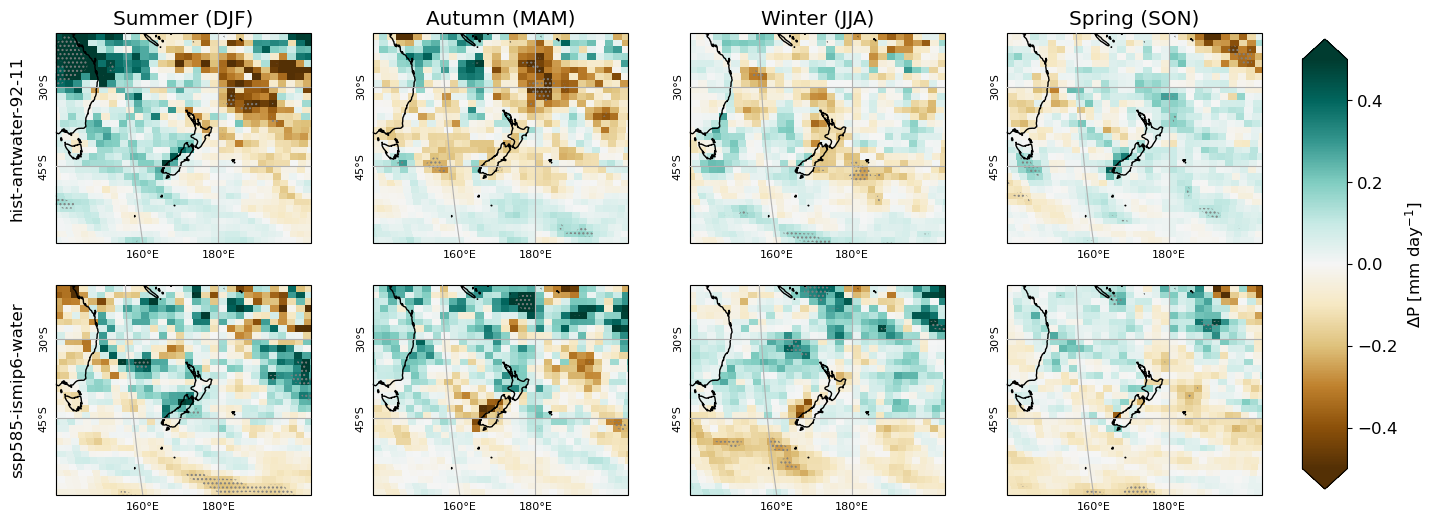

In [18]:
fig, axs = plt.subplots(
    2,
    4,
    figsize=(18, 6),
    subplot_kw={"projection": ccrs.Robinson(central_longitude=180)},
)
imdict = {}
for n, exp in enumerate(expts):
    for s, seas in enumerate(tanom.season.data):
        dplt = anomdictseas[exp].sel(season=seas)
        pplt = pvaldictseas[exp].sel(season=seas)

        if n == 0:
            imdict[exp] = plotnz(axs[n, s], dplt, pplt, seasdict[seas], climdict[exp])
        else:
            imdict[exp] = plotnz(axs[n, s], dplt, pplt, "", climdict[exp])

axs[0, 0].annotate(
    "hist-antwater-92-11",
    xy=(-0.15, 0.5),
    xycoords="axes fraction",
    rotation=90,
    ha="center",
    va="center",
)

axs[1, 0].annotate(
    "ssp585-ismip6-water",
    xy=(-0.15, 0.5),
    xycoords="axes fraction",
    rotation=90,
    ha="center",
    va="center",
)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.12, 0.025, 0.75])
cb = plt.colorbar(imdict["historical"], cax=cbar_ax, extend="both")
cb.set_label("$\Delta$P [mm day$^{-1}$]")

fig.savefig(
    f"../figures/pr_seas_sofia_tier2_combined_nz_20240627.png",
    bbox_inches="tight",
    dpi=300,
)